## Task and Approach:
We need to work on the Book-Crossing Dataset and build a model to recommend books to the end users

In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 

from sklearn.metrics.pairwise import cosine_similarity  
from scipy import sparse 
from scipy.sparse.linalg import svds 

import warnings  
warnings.filterwarnings("ignore")

In [3]:
import os
path = '/home/srgrace/genericContest_data/Recommender_System/'

Users_location = pd.read_csv(os.path.join(path, 'BX-Users.csv'),encoding='latin-1') 
User_Book_Ratings = pd.read_csv(os.path.join(path, 'BX-Book-Details-Ratings.csv'),encoding='latin-1') ##Book details 

In [5]:
Users_location.shape, User_Book_Ratings.shape


((276271, 5), (25387, 8))

In [6]:
Users_location.head()

,User-ID,Location,Age,Unnamed: 3,Unnamed: 4
0,1.0,nyc,NaN,NaN,NaN
1,2.0,stockton,NaN,NaN,NaN
2,3.0,moscow,NaN,NaN,NaN
3,4.0,porto,NaN,NaN,NaN
4,5.0,farnborough,NaN,NaN,NaN


In [7]:
User_Book_Ratings.head()

,User-ID,BookID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,19,1,60914068,3,Love,0,0,0
1,19,2,156047624,10,All the King's Men,Robert Penn Warren,1982,Harvest Books
2,19,3,245542957,6,Pacific Northwest,Hans Johannes Hoefer,1985,Chambers Harrap Publishers Ltd
3,19,4,380715899,9,A Soldier of the Great War,Mark Helprin,1992,Avon Books
4,19,5,553280333,0,Getting Well Again,O. Carol Simonton Md,1992,Bantam


In [11]:
Users_location.isnull().sum(axis = 0)


User-ID       223029
Location      223130
Age           276271
Unnamed: 3    276271
Unnamed: 4    276271
dtype: int64

In [13]:
# drop null > 85% columns

Users_location = Users_location[['User-ID','Location']]
Users_location.tail()

,User-ID,Location
276266,278854.0,portland
276267,278855.0,tacoma
276268,278856.0,brampton
276269,278857.0,knoxville
276270,278858.0,dublin


In [14]:
User_Book_Ratings.isnull().sum(axis = 0)


User-ID                0
BookID                 0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [15]:
Users_location.isnull().sum(axis = 0)

User-ID     223029
Location    223130
dtype: int64

In [16]:
Users_location.rename(columns={'User-ID':'UserID'}, inplace=True)
User_Book_Ratings.rename(columns={'User-ID':'UserID'}, inplace=True)
User_Book_Ratings.rename(columns={'Book-Rating':'BookRating'}, inplace=True)

In [17]:
Book_Ratings_loc = pd.merge(Users_location, User_Book_Ratings, on = 'UserID', how='right')
Book_Ratings_loc.head()

,UserID,Location,BookID,ISBN,BookRating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,19.0,weston,1,60914068,3,Love,0,0,0
1,19.0,weston,2,156047624,10,All the King's Men,Robert Penn Warren,1982,Harvest Books
2,19.0,weston,3,245542957,6,Pacific Northwest,Hans Johannes Hoefer,1985,Chambers Harrap Publishers Ltd
3,19.0,weston,4,380715899,9,A Soldier of the Great War,Mark Helprin,1992,Avon Books
4,19.0,weston,5,553280333,0,Getting Well Again,O. Carol Simonton Md,1992,Bantam


In [18]:
# Over All summary of the dataset

def df_summary(df):
    df_U = df.nunique()
    df_U = df_U.to_frame().reset_index()
    
    df_M = df.isnull().sum()
    df_M = df_M.to_frame().reset_index()
    
    df_I = df.dtypes
    df_I = df_I.to_frame().reset_index()
    
    df_U = df_U.rename(columns= {0: 'Unique Data'})
    df_M = df_M.rename(columns= {0: 'Missing Data'})
    df_I = df_I.rename(columns= {0: 'Data Types'})
    
    output = pd.merge(pd.merge(df_M,df_U,on='index'),df_I,on='index')
    return output

df_summary(Book_Ratings_loc)

,index,Missing Data,Unique Data,Data Types
0,UserID,0,266,float64
1,Location,198,232,object
2,BookID,0,25387,int64
3,ISBN,0,25387,int64
4,BookRating,0,11,int64
5,Book-Title,0,23853,object
6,Book-Author,0,12061,object
7,Year-Of-Publication,0,71,object
8,Publisher,0,2917,object


In [19]:
# Replace the missing values with 'None'

Book_Ratings_loc['Location'].fillna('None', inplace=True)


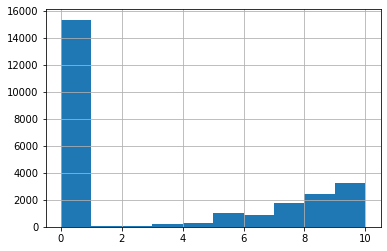

In [20]:
Book_Ratings_loc['BookRating'].hist(bins=10);


Most of the data contains '0' ratings

In [21]:
Book_Ratings_loc['Book-Author'].value_counts()


0                        3317
Stephen King              117
Agatha Christie           100
William Shakespeare        64
Nora Roberts               56
Danielle Steel             51
Marion Zimmer Bradley      48
Sandra Brown               48
Anne McCaffrey             47
Carolyn Keene              44
Roald Dahl                 41
Jane Austen                39
Golden Books               39
V.C. Andrews               38
Orson Scott Card           37
Mary Higgins Clark         37
Piers Anthony              37
James A. Michener          37
R.L. Stine                 36
Dick Francis               35
Charles Dickens            33
Sidney Sheldon             32
Robert Ludlum              32
James Patterson            31
Catherine Coulter          31
Ngaio Marsh                31
Francine Pascal            31
Andrew M. Greeley          31
Barbara Delinsky           30
Dean R. Koontz             29
                         ... 
Holden Scott                1
Robert Nye                  1
Vincent Pr

In [23]:
# After seeing 0 values for the author name we can replace it as (not mentioned) in the dataset

Book_Ratings_loc['Book-Author'].replace('0','Not - mentioned', inplace=True)

Book_Ratings_loc['Book-Author'].value_counts()


Not - mentioned           3317
Stephen King               117
Agatha Christie            100
William Shakespeare         64
Nora Roberts                56
Danielle Steel              51
Marion Zimmer Bradley       48
Sandra Brown                48
Anne McCaffrey              47
Carolyn Keene               44
Roald Dahl                  41
Jane Austen                 39
Golden Books                39
V.C. Andrews                38
Piers Anthony               37
James A. Michener           37
Mary Higgins Clark          37
Orson Scott Card            37
R.L. Stine                  36
Dick Francis                35
Charles Dickens             33
Sidney Sheldon              32
Robert Ludlum               32
Francine Pascal             31
Catherine Coulter           31
Ngaio Marsh                 31
Andrew M. Greeley           31
James Patterson             31
Barbara Delinsky            30
Dean R. Koontz              29
                          ... 
Ngaio March                  1
Francis 

In [24]:
# location-wise count

Book_Ratings_loc['Location'].value_counts()


melbourne                       6958
juneau                          1476
milano                          1086
yogyakarta                       768
saratoga                         684
chicago                          610
vilanova i la geltrú             585
flensburg                        553
riverside                        437
la mirada                        402
ankara                           385
barcelona                        379
west orange                      352
oakland                          350
madriz                           290
roma                             273
del mar                          262
ottawa                           236
ranchi                           228
launceston                       209
oakdale                          205
san mateo                        201
None                             198
ann arbor                        198
selvazzano dentro                185
helsinki                         179
united states                    172
p

* UserID wise counts

* How many books associated with each user ID .

In [26]:
Book_Ratings_loc.groupby('UserID')['ISBN'].count()

UserID
19.0        7
41.0       11
50.0        2
61.0        6
62.0        2
64.0        5
71.0        1
78.0       26
79.0       69
82.0      262
112.0       8
152.0      12
153.0     113
180.0      64
192.0       1
199.0      19
213.0      56
221.0       3
227.0       5
231.0       4
249.0      94
260.0      11
264.0      49
289.0      42
292.0       1
301.0       1
317.0      34
334.0       1
342.0       1
345.0       1
         ... 
3927.0      7
3944.0     46
3964.0     11
3966.0    103
3988.0     18
4015.0      7
4085.0     32
4106.0     55
4124.0    122
4144.0      1
4184.0      6
4192.0     26
4230.0     84
4240.0     11
4263.0      2
4264.0     11
4282.0     16
4302.0      8
4310.0    324
4326.0    111
4365.0      9
4491.0      1
4522.0      6
4529.0     23
4532.0    201
4558.0     75
4562.0      5
4616.0     74
4765.0     17
4774.0     75
Name: ISBN, Length: 266, dtype: int64

In [27]:
Book_Ratings_loc['Book-Title'].value_counts()


I                                                                                   17
Love                                                                                11
1                                                                                   10
Diana-TaschenbÃ?Â¼cher                                                               9
Happy Birthday                                                                       8
Baby                                                                                 8
Wuthering Heights                                                                    8
The Lion                                                                             8
Pride and Prejudice                                                                  7
Oh                                                                                   7
Beloved                                                                              7
Journey                                    

In [28]:
Book_Ratings_loc.UserID = Book_Ratings_loc['UserID'].astype(int)
Book_Ratings_loc.dtypes

UserID                  int64
Location               object
BookID                  int64
ISBN                    int64
BookRating              int64
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
dtype: object

In [29]:
Book_Ratings_loc.head()


,UserID,Location,BookID,ISBN,BookRating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,19,weston,1,60914068,3,Love,Not - mentioned,0,0
1,19,weston,2,156047624,10,All the King's Men,Robert Penn Warren,1982,Harvest Books
2,19,weston,3,245542957,6,Pacific Northwest,Hans Johannes Hoefer,1985,Chambers Harrap Publishers Ltd
3,19,weston,4,380715899,9,A Soldier of the Great War,Mark Helprin,1992,Avon Books
4,19,weston,5,553280333,0,Getting Well Again,O. Carol Simonton Md,1992,Bantam


* Creating Pivot tale w.r.to User ID & book Title on the bases of Book rating


In [30]:
User_Rating = Book_Ratings_loc.pivot_table(index='UserID', columns='Book-Title', values='BookRating')
User_Rating.head()

Book-Title,A Light in the Storm: The Civil War Diary of Amelia Martin,Beyond IBM: Leadership Marketing and Finance for the 1990s,Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),Mystery Mile,Q-Space (Star Trek The Next Generation,' Small g'. Eine Sommeridylle.,'Eine gute Frau hat keinen Kopf'. EuropÃ?Â¤ische SprichwÃ?Â¶rter Ã?Â¼ber Frauen.,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Romance of Paula Vaughn','Til There Was You (Special Edition,...,the Heiress Bride (sister brides),wet sand,whataboutrick.com: a poetic tribute to Richard A. Ricci,Â¡Corre,Â¿QuÃ© me quieres,Ã?Â?ber das Fernsehen.,Ã?Â?ber die Freiheit.,Ã?Â?ber die Pflicht zum Ungehorsam gegen den Staat.,Ã?Â?bermorgen.,Ã?Â?lpiraten.
UserID,,,,,,,,,,,,,,,,,,,,,
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
User_Rating.loc[~(User_Rating["Baby"].isnull()), "Baby"]


UserID
2021    10.000000
2079     0.000000
2738     0.000000
2753     6.333333
3329     0.000000
Name: Baby, dtype: float64

In [32]:
# Calculate mean rating of all Books

Book_Stats = pd.DataFrame(Book_Ratings_loc.groupby('Book-Title')['BookRating'].mean())
Book_Stats.sort_values(by = ['BookRating'],ascending=False).head() 

,BookRating
Book-Title,
The Baby Book: Everything You Need to Know About Your Baby from Birth to Age Two,10.0
Aristocrats: Caroline,10.0
Essentials of Computational Chemistry : Theories and Models,10.0
Et si c'Ã?Â©tait vrai...,10.0
Are You My Mother?,10.0


In [33]:
# Calculate count rating of all Books 

Book_Stats['Count_of_ratings'] = pd.DataFrame(Book_Ratings_loc.groupby('Book-Title')['BookRating'].count())
Book_Stats.sort_values(by =['Count_of_ratings'], ascending=False).head()

,BookRating,Count_of_ratings
Book-Title,,
I,3.000000,17
Love,3.727273,11
1,3.100000,10
Diana-TaschenbÃ?Â¼cher,3.777778,9
Baby,3.625000,8


Now we know that both the average rating per book and the number of ratings per Books are important attributes

## Correlation SImilarity

* We can achieve this by computing the correlation between these two books’ ratings and the ratings of the rest of the books in the dataset.
* The first step is to create a dataframe with the ratings of these books

Example pick up one Book related rating

In [34]:
# We can find the correlation between the user ratings for the given Books and all the other Books using 
# corrwith() function as shown below

Similarity = User_Rating.corrwith(User_Rating['Baby'])
Similarity.head()

Book-Title
 A Light in the Storm: The Civil War Diary of Amelia Martin          NaN
 Beyond IBM: Leadership Marketing and Finance for the 1990s          NaN
 Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback))   NaN
 Mystery Mile                                                        NaN
 Q-Space (Star Trek The Next Generation                              NaN
dtype: float64

In [35]:
corr_similar = pd.DataFrame(Similarity, columns=['Correlation'])
corr_similar.sort_values(['Correlation'], ascending= False).head(10)

,Correlation
Book-Title,
1,1.0
Portnoy's Complaint,1.0
Vanished,1.0
Think on These Things,1.0
The Switch,1.0
The Prince and the Pilgrim,1.0
The Inheritance,1.0
The Daughters of Cain,1.0
Second Wind,1.0


In [36]:
corr_similar_num_of_rating = corr_similar.join(Book_Stats['Count_of_ratings'])
corr_similar_num_of_rating.sort_values(['Correlation'], ascending= False).head(10)

,Correlation,Count_of_ratings
Book-Title,,
1,1.0,10
Portnoy's Complaint,1.0,3
Vanished,1.0,6
Think on These Things,1.0,2
The Switch,1.0,2
The Prince and the Pilgrim,1.0,2
The Inheritance,1.0,2
The Daughters of Cain,1.0,2
Second Wind,1.0,2


In [37]:
corr_similar_num_of_rating[corr_similar_num_of_rating ['Count_of_ratings']>5].sort_values('Correlation', 
                                                                                          ascending=False).head()

,Correlation,Count_of_ratings
Book-Title,,
1,1.0,10
Baby,1.0,8
Journey,1.0,7
Vanished,1.0,6
20,NaN,6


In [40]:
def get_recommendations(title):
    # Get the book ratings of the book that matches the title
    rating = User_Rating[title]

    # Get the  similarity correlated  scores of all books with that book
    sim_scores = User_Rating.corrwith(rating)

    # Sort the books based on the similarity scores
    corr_title = pd.DataFrame(sim_scores, columns=['Correlation'])
    
    # Removing na values 
    corr_title.dropna(inplace=True)
    
    corr_title = corr_title.join(Book_Stats['Count_of_ratings'])
    
    # Return the top 10 most similar books
    return corr_title[corr_title ['Count_of_ratings']>5].sort_values('Correlation', ascending=False).head(10)

In [41]:
get_recommendations('Baby')


,Correlation,Count_of_ratings
Book-Title,,
1,1.0,10
Baby,1.0,8
Journey,1.0,7
Vanished,1.0,6


## Cosine Similarity

* Untill now we have seen the correlation wise now we are going to use cosine similariy to find the similar Books
* Filter out required columns from the dataset

In [42]:
Book_cosine = Book_Ratings_loc[['UserID','BookID','BookRating']]
Book_cosine.head()

,UserID,BookID,BookRating
0,19,1,3
1,19,2,10
2,19,3,6
3,19,4,9
4,19,5,0


* Sparse matrix we are going to create using above data
* A sparse matrix in Coordinate format this is also called as triplet format

In [43]:
data = Book_Ratings_loc.BookRating
col = Book_Ratings_loc.BookID
row = Book_Ratings_loc.UserID

R = sparse.coo_matrix((data, (row, col))).tocsr()
print ('{0}x{1} user by Book matrix'.format(*R.shape))
#print(data.shape)
print(R.shape)

4775x25388 user by Book matrix
(4775, 25388)


* Keeping data ,col,row we called as Triplet Format of Matrix

* The individual elements of the matrix can be listed in any order, and if there are multiple items for the same nonzero position, the values provided for those positions are added.

* Using the cosine similarity to measure the similarity between a pair of vectors

* With the cosine similarity, we are going to evaluate the similarity between two vectors based on the angle between them. The smaller the angle, the more similar the two vectors are

* If you recall from trigonometry, the range of the cosine function goes from -1 to 1. Some important properties of cosine to recall:

    Cosine(0°) = 1 <br>
    Cosine(90°) = 0 <br>
    Cosine(180°) = -1 <br>
    
    
* If we restrict our vectors to non-negative values (as in the case of Book ratings, usually going from a 0-10 scale), then the angle of separation between the two vectors is bound between 0° and 90°

In [44]:
find_similarities = cosine_similarity(R.T) # We are transposing the matrix 
print (find_similarities)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [45]:
def Get_Top5_Similarbooks(model, book_id, n=5):
    return model[book_id].argsort()[::-1][:n].tolist()  # Here book id is index

In [46]:
Book_Ratings_loc.loc[Get_Top5_Similarbooks(find_similarities, 10), ["UserID", "BookID", "Book-Title"]]


,UserID,BookID,Book-Title
15,41,16,Creating Wealth : Retire in Ten Years Using Al...
9,41,10,Pasquale's Nose: Idle Days in an Italian Town
16,41,17,Love
14,41,15,McDonald's: Behind the Arches
13,41,14,The Pillars of the Earth


## Matrix Facrtorization
### #Singular Value Decomposition (Matrix Factorization)
* df_array=UΣVT
 
Now using Singular Value Decomposition, we will decompose our dataframe into smaller matrices. This can be done directly with the help of scipy using scipy.sparse.linalg.svds.

In [47]:
df_matrix = User_Rating.fillna(0)


In [48]:
normalized_values = df_matrix.values - np.mean(df_matrix.values, axis=1).reshape(-1,1)
normalized_values

array([[-0.00117386, -0.00117386, -0.00117386, ..., -0.00117386,
        -0.00117386, -0.00117386],
       [-0.00255733, -0.00255733, -0.00255733, ..., -0.00255733,
        -0.00255733, -0.00255733],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00586928, -0.00586928, -0.00586928, ..., -0.00586928,
        -0.00586928, -0.00586928],
       [-0.00062885, -0.00062885, -0.00062885, ..., -0.00062885,
        -0.00062885, -0.00062885],
       [-0.00901354, -0.00901354, -0.00901354, ..., -0.00901354,
        -0.00901354, -0.00901354]])

In [49]:
U, SIGMA, VT = svds(normalized_values)
U.shape, SIGMA.shape, VT.shape

((266, 6), (6,), (6, 23853))

In [50]:
SIGMA = np.diag(SIGMA)

In [51]:
U.shape, SIGMA.shape, VT.shape

((266, 6), (6, 6), (6, 23853))

In [52]:
df_matrix

Book-Title,A Light in the Storm: The Civil War Diary of Amelia Martin,Beyond IBM: Leadership Marketing and Finance for the 1990s,Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),Mystery Mile,Q-Space (Star Trek The Next Generation,' Small g'. Eine Sommeridylle.,'Eine gute Frau hat keinen Kopf'. EuropÃ?Â¤ische SprichwÃ?Â¶rter Ã?Â¼ber Frauen.,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Romance of Paula Vaughn','Til There Was You (Special Edition,...,the Heiress Bride (sister brides),wet sand,whataboutrick.com: a poetic tribute to Richard A. Ricci,Â¡Corre,Â¿QuÃ© me quieres,Ã?Â?ber das Fernsehen.,Ã?Â?ber die Freiheit.,Ã?Â?ber die Pflicht zum Ungehorsam gegen den Staat.,Ã?Â?bermorgen.,Ã?Â?lpiraten.
UserID,,,,,,,,,,,,,,,,,,,,,
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
reconstructed_df = np.dot(np.dot(U, SIGMA), VT) + np.mean(df_matrix.values, axis=1).reshape(-1, 1)
predictions_df = pd.DataFrame(reconstructed_df, columns = df_matrix.columns)
predictions_df

Book-Title,A Light in the Storm: The Civil War Diary of Amelia Martin,Beyond IBM: Leadership Marketing and Finance for the 1990s,Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),Mystery Mile,Q-Space (Star Trek The Next Generation,' Small g'. Eine Sommeridylle.,'Eine gute Frau hat keinen Kopf'. EuropÃ?Â¤ische SprichwÃ?Â¶rter Ã?Â¼ber Frauen.,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,'Romance of Paula Vaughn','Til There Was You (Special Edition,...,the Heiress Bride (sister brides),wet sand,whataboutrick.com: a poetic tribute to Richard A. Ricci,Â¡Corre,Â¿QuÃ© me quieres,Ã?Â?ber das Fernsehen.,Ã?Â?ber die Freiheit.,Ã?Â?ber die Pflicht zum Ungehorsam gegen den Staat.,Ã?Â?bermorgen.,Ã?Â?lpiraten.
0,1.308094e-03,1.308094e-03,1.308094e-03,1.308094e-03,1.308094e-03,1.310869e-03,9.669803e-04,1.308094e-03,1.308094e-03,1.308094e-03,...,1.308094e-03,-5.636195e-05,4.553092e-04,-3.974760e-04,1.308094e-03,-5.636195e-05,1.311332e-03,1.308094e-03,1.308094e-03,1.308094e-03
1,3.179429e-03,3.179429e-03,3.179429e-03,3.179429e-03,3.179429e-03,3.212939e-03,2.369281e-03,3.179429e-03,3.179429e-03,3.179429e-03,...,3.179429e-03,-6.116388e-05,1.154058e-03,-8.713121e-04,3.179429e-03,-6.116388e-05,3.218525e-03,3.179429e-03,3.179429e-03,3.179429e-03
2,-2.691783e-16,-2.691783e-16,-2.691783e-16,-2.691783e-16,-2.691783e-16,-3.088175e-16,-6.226666e-17,-2.691783e-16,-2.691783e-16,-2.691783e-16,...,-2.691783e-16,5.584682e-16,2.481007e-16,7.653798e-16,-2.691783e-16,5.584682e-16,-3.154240e-16,-2.691783e-16,-2.691783e-16,-2.691783e-16
3,1.669658e-03,1.669658e-03,1.669658e-03,1.669658e-03,1.669658e-03,1.687088e-03,1.242784e-03,1.669658e-03,1.669658e-03,1.669658e-03,...,1.669658e-03,-3.783788e-05,6.024731e-04,-4.647118e-04,1.669658e-03,-3.783788e-05,1.689993e-03,1.669658e-03,1.669658e-03,1.669658e-03
4,-1.415358e-04,-1.415358e-04,-1.415358e-04,-1.415358e-04,-1.415358e-04,-1.498057e-04,7.489024e-04,-1.415358e-04,-1.415358e-04,-1.415358e-04,...,-1.415358e-04,3.420217e-03,2.084560e-03,4.310655e-03,-1.415358e-04,3.420217e-03,-1.511840e-04,-1.415358e-04,-1.415358e-04,-1.415358e-04
5,-8.792576e-17,-8.792576e-17,-8.792576e-17,-8.792576e-17,-8.792576e-17,-1.008695e-16,-2.018939e-17,-8.792576e-17,-8.792576e-17,-8.792576e-17,...,-8.792576e-17,1.830197e-16,8.141516e-17,2.507561e-16,-8.792576e-17,1.830197e-16,-1.030268e-16,-8.792576e-17,-8.792576e-17,-8.792576e-17
6,4.195486e-04,4.195486e-04,4.195486e-04,4.195486e-04,4.195486e-04,4.242695e-04,3.116013e-04,4.195486e-04,4.195486e-04,4.195486e-04,...,4.195486e-04,-1.224068e-05,1.496803e-04,-1.201880e-04,4.195486e-04,-1.224068e-05,4.250563e-04,4.195486e-04,4.195486e-04,4.195486e-04
7,9.581013e-03,9.581013e-03,9.581013e-03,9.581013e-03,9.581013e-03,9.688751e-03,7.127235e-03,9.581013e-03,9.581013e-03,9.581013e-03,...,9.581013e-03,-2.340989e-04,3.446568e-03,-2.687877e-03,9.581013e-03,-2.340989e-04,9.706707e-03,9.581013e-03,9.581013e-03,9.581013e-03
8,5.224820e-03,5.224820e-03,5.224820e-03,5.224820e-03,5.224820e-03,5.273056e-03,5.174406e-03,5.224820e-03,5.224820e-03,5.224820e-03,...,5.224820e-03,5.023164e-03,5.098785e-03,4.972750e-03,5.224820e-03,5.023164e-03,5.281096e-03,5.224820e-03,5.224820e-03,5.224820e-03
9,1.706922e-02,1.706922e-02,1.706922e-02,1.706922e-02,1.706922e-02,1.705237e-02,1.506904e-02,1.706922e-02,1.706922e-02,1.706922e-02,...,1.706922e-02,9.068504e-03,1.206877e-02,7.068326e-03,1.706922e-02,9.068504e-03,1.704956e-02,1.706922e-02,1.706922e-02,1.706922e-02


In [54]:
def user_ratings(user_id, df):
    df1 = df[df['UserID'] == user_id].sort_values(['BookRating'], ascending=False).copy()
    return df1

In [55]:
user_ratings(19, User_Book_Ratings)


,UserID,BookID,ISBN,BookRating,Book-Title,Book-Author,Year-Of-Publication,Publisher
1,19,2,156047624,10,All the King's Men,Robert Penn Warren,1982,Harvest Books
3,19,4,380715899,9,A Soldier of the Great War,Mark Helprin,1992,Avon Books
2,19,3,245542957,6,Pacific Northwest,Hans Johannes Hoefer,1985,Chambers Harrap Publishers Ltd
0,19,1,60914068,3,Love,0,0,0
4,19,5,553280333,0,Getting Well Again,O. Carol Simonton Md,1992,Bantam
5,19,6,961769947,0,Northwest Wines and Wineries,Chuck Hill,1993,Speed Graphics
6,19,7,964778319,0,An Atmosphere of Eternity: Stories of India,David Iglehart,2002,Sunflower Press


As you can see above, the predictions_df shows values of ratings very close to the actual ratings given by users to the Books in the df_matrix dataframe. The remaining values in predictions_df of which corresponding cells are 0 in df_matrix, are the predicted ratings from the multiplication of the factors that we decomposed the df_matrix into.

Let's create some helper functions to find out what a user's ratings and the genres which the user rates the highest.

In [58]:
def get_recommendations(UserID, number_of_recommendations=10):
    df1 = User_Book_Ratings[~User_Book_Ratings['BookID'].isin(User_Book_Ratings[User_Book_Ratings['UserID'] == UserID] \
                                        .sort_values(['BookRating'], ascending=False)['BookID'])] \
                                        .merge(pd.DataFrame(predictions_df.iloc[UserID - 1] \
                                                            .sort_values(ascending=False)) \
                                               .reset_index(), \
                                               how='left', left_on='Book-Title', right_on='Book-Title') \
                                        .sort_values(UserID - 1, ascending=False) \
                                        .iloc[:number_of_recommendations, :]
    return df1

In [59]:
get_recommendations(100)

,UserID,BookID,ISBN,BookRating,Book-Title,Book-Author,Year-Of-Publication,Publisher,99
1806,613,1807,425047253,10,Northern Girl,Elizabeth A. Lynn,1981,Berkley Publishing Group,8.740041e-15
1770,613,1771,345379144,10,Zombies of the Gene Pool,Sharyn McCrumb,1996,Fawcett Books,8.740041e-15
9043,2428,9044,425061957,0,Watchtower,Elizabeth A. Lynn,1983,Berkley Publishing Group,8.740041e-15
2018,613,2019,756400147,10,Child of Flame (Crown of Stars,0,0,0,8.740041e-15
9044,2428,9045,425063879,0,Northern Girl,Elizabeth A. Lynn,1983,Berkley Publishing Group,8.740041e-15
2012,613,2013,684803976,10,PENNY SAVED,Tad Richards,1995,Simon &amp; Schuster,8.740041e-15
2009,613,2010,671876015,10,Pigs Don't Fly,Mary Brown,1994,Baen,8.740041e-15
1798,613,1799,399146725,10,The Jury,Steve Martini,2001,G. P. Putnam's Sons,8.740041e-15
1996,613,1997,671797050,10,FIRST WIVES CLUB,Olivia Goldsmith,1993,Pocket,8.740041e-15
1987,613,1988,671721178,10,Liar'S Oath,Elizabeth Moon,1992,Baen,8.740041e-15
